# Day 1 - Introduction to FluCoMa

Coding, as the codification of rules, becomes really tricky if a precise forumlation of the rules of a given problem to really hard - e.g. what would be a good rule to detect a face in a picture?
Machine learnining algorithms can help in such a case as they provide a way to use data to adjust and align possible rules within a given algorithm through data.
But of course this also comes with a trade off: one has now instead to solve the problem to figure out a good algorithm so it can detect the patterns within the data, data and more computing resources become necessary and it becomes difficult or impossible to improve or understand the algorithm by tweaking it.

Although most Machine Learning is performed within Python these days, FluCoMa provides a really unique way to interact with real time audio data by running in a DSP environment, which allows the capabilities of data pattern extraction to be applied upon real time audio data in a variety of environments such as SuperCollider, MaxMSP and pd.
This is not really feasible within Python.

This course will therefore will not cover advanced architectures such as the transformer architecture which is used by Chat GPT (Chat **G**enerative **P**re-trained **T**ransformer) as there are already dedicated Python frameworks to this specific kind of architecture.
Instead we will focus on smaller and simpler algorithms as they are easier to understand, work with and also fit our requirement to be computable within realtime - which means thousands of times per second in a time-critical environment.
A recommended book for a general introduction into machine learning is {cite}`handsonml`, the [scikit-learn user guide](https://scikit-learn.org/stable/user_guide.html) and the [PyTorch tutorials](https://scikit-learn.org/stable/user_guide.html).

So lets start by installing FluCoMa for SuperCollider.

## Installation

In order to install FluCoMa head over to <https://www.flucoma.org/download/> and download the matching version for your operating system. 
Copy the content of the archive to the extension directory which can be opened by executing the following line from within SuperCollider (the exact path is different for every user/computer, so make sure to execute it).

In [10]:
Platform.userExtensionDir.openOS;

-> /Users/scheiba/Library/Application Support/SuperCollider/Extensions

```{note}
Make sure that you have a matching version of SuperCollider version - the newest SuperCollider version should always be compatible with the newest FluCoMa version.
```

After copying the file restart the SuperCollider interpreter (click on *Language->Restart interpreter* on the menu of the IDE) and start to type `Fluid` into a Document - if the autocompletion with classes such as `FluidAmpFeature` appear the language part of FluCoMa has been sucessfully installed for SuperCollider.

The next step is to boot the server which can be done via

In [11]:
s.reboot;

-> localhost

```{note}
If the server crashes during booting this is probably due to a incompatible SuperCollider and FluCoMa versions.
Please check the FluCoMa website for more information.
```

## The project

The first project we want to use to get into FluCoMa will be a 2D map of kick drum sounds so we can navigate through the map of kick sounds with our mouse.
Sounds which are similar should be mapped into a similar location, so islands of similar sounds can be created.

The general structure will be

* load the dataset
* try to find a good representation of our data through statistical means
* train a dimensionality reduction algorithm (in this example we will focus on [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)
* explore what the algorithm did
* apply it in a real time environment on the server

### Loading the dataset

In my example I will use the [*Creative kick drum samples*](https://www.musicradar.com/news/sampleradar-creative-kick-drum-samples) collection from music radar.
You are invited to choose your own dataset of files.
In order to keep things simple really short samples (not longer than 1 second) between 100 and 1000 samples are recommended - though they don't have to be only of one class (e.g. kick drum).

```{note}
One thing to keep in mind: As we start to parse data it is also crucial that this data is also somehow uniform in regards to technical parameters.
The files should share a common sample rate, bitrate and format.
Tools like [`ffmpeg`](https://ffmpeg.org/) are invaluable to convert media into a common format.
```

In order to keep things more simple we will limit the dataset to mono samples (i.e. we assume that the stereo seperation of a kick drum is neglectable in order to differentiate them).


In [12]:
~sampleBuffers = [];
PathName("/Users/scheiba/supercollider/Creative Kicks/").filesDo({|file|
	~sampleBuffers = ~sampleBuffers.add(Buffer.readChannel(
		server: s,
		path: file.asAbsolutePath,
		// only mono
		channels: 0,
	));
});
"Loaded % samples".format(~sampleBuffers.size).postln;

Loaded 490 samples
-> Loaded 490 samples

It is always a good to verify the data structure on every step.
If the data becomes misaligned for some reason it becomes impossible for the algorithm to extract any data.

In [13]:
~sampleBuffers.choose.postln.play;

Buffer(255, 81439, 1, 44100.0, /Users/scheiba/supercollider/Creative Kicks/Electronic Kicks/Electronic Kick 77.wav)
-> Synth('temp__0' : 1000)

## Analyze and represent the data

The next step is tyring to represent each kick drum sample through a mathematical high level abstraction: a vector, which can be seen as a position in a high dimensional room, is the way to go here.

We will come up with different extraction parameters which try to capture the charateristics of the kick drum sample (e.g. length, loudest frequency, ...), where each parameter becomes a dimension in the parameter room.
There is a trade-off between excessive parameters and.
And while operating and navigating in a high dimensional room is somehow feasible within mathematics (be aware of the *course of dimensionality* though), it becomes impratical when interacting with it as a person.
This is the reason why we perform a dimensionality reduction - we first try to come up with a mathematical representation of our samples and later try to compress the information of this representation down to two dimensions.

```{note}
The crafting of good parameters is an art in itself and is worth spending some thought and time upon as it provides the senses for the model to comprehend the data.
The more complex the data becomes, the more difficult it gets to compose meaningful feature representation of the given data.

Deep learning, which is a term for neural networks with a larger amount of hidden layers, allowed to find ways to come up with feauter extraction methods as part of its learning process.
```

We will first analyze a single sample and later construct a dataset, which stores the mathematical vector representation of each sample.

In [14]:
~sample = ~sampleBuffers.choose;
~sample.postln.play;

Buffer(56, 46336, 1, 44100.0, /Users/scheiba/supercollider/Creative Kicks/Accoustic Kicks/Accoustic Kick 57.wav)
-> Synth('temp__1' : 1001)

FluCoMa offers a wide variety of information extraction tool of sonic data - for this introduction we will limit ourselves to `FluidBufSpectralShape` which extracts such information such as *spectral centroid*.

As FluCoMa supports not just SuperCollider but also pd and Max MSP it is necessary to perform all FluCoMa related tasks on a format which is supported by all these frameworks which are audio signals and in particular, *buffers*.

In SuperCollider, Buffers are normally used to store an audio sample, but effectively it simply represents data as a list of floating point numbers and can therefore also be used as a storage for such.

Our kick drum sample is already a buffer, but the result of the FluCoMa analysis will also be stored in a Buffer - so we need to create such a buffer on our server.
Allocating buffers on the server is a common task and because of the split between sclang as a language which tells scsynth, the server, what to perform, one needs to perform extra caution here.
Two useful articles from the SuperCollider Documentation are therefore

* s.sync
* Interpreter vs server


In [15]:
// a buffer to store the result of the spectral analysis
~spectralBuffer = Buffer.alloc(server: s,numFrames: 1);

FluidBufSpectralShape.processBlocking(
	server: s,
	source: ~sample,
    features: ~spectralBuffer,
);

// acts as s.sync to wait for the server to catch up
~spectralBuffer.loadToFloatArray;

~spectralBuffer;

-> Buffer(490, 91, 7, 86.1328125, nil)

We can take a a look at the data which was returned from FluCoMa.

The buffer `~targetBuffer` contains e.g. $132$ frames and $7$ channels - which could be read as a excel speradsheet with $7$ columns and $132$ rows.
The spectral centroid for our sample is not just calculated once for the whole sample but for each small time-window of the sample - therefore the longer the sample is, the more rows we will obtain.

The $7$ channels of the buffer (aka the columns) represent the different kind of analysis that `FluidBufSpectralShape` performed on the buffer, such as *spectral centroid*, *spectral spread*, ... - for a complete list, please check out the documentation of FluCoMa and Wikipedia.

$$
B_\text{spectral}: \underbrace{n}_{\text{\#} windows} \times \underbrace{m}_{\text{\# analysis}}
$$

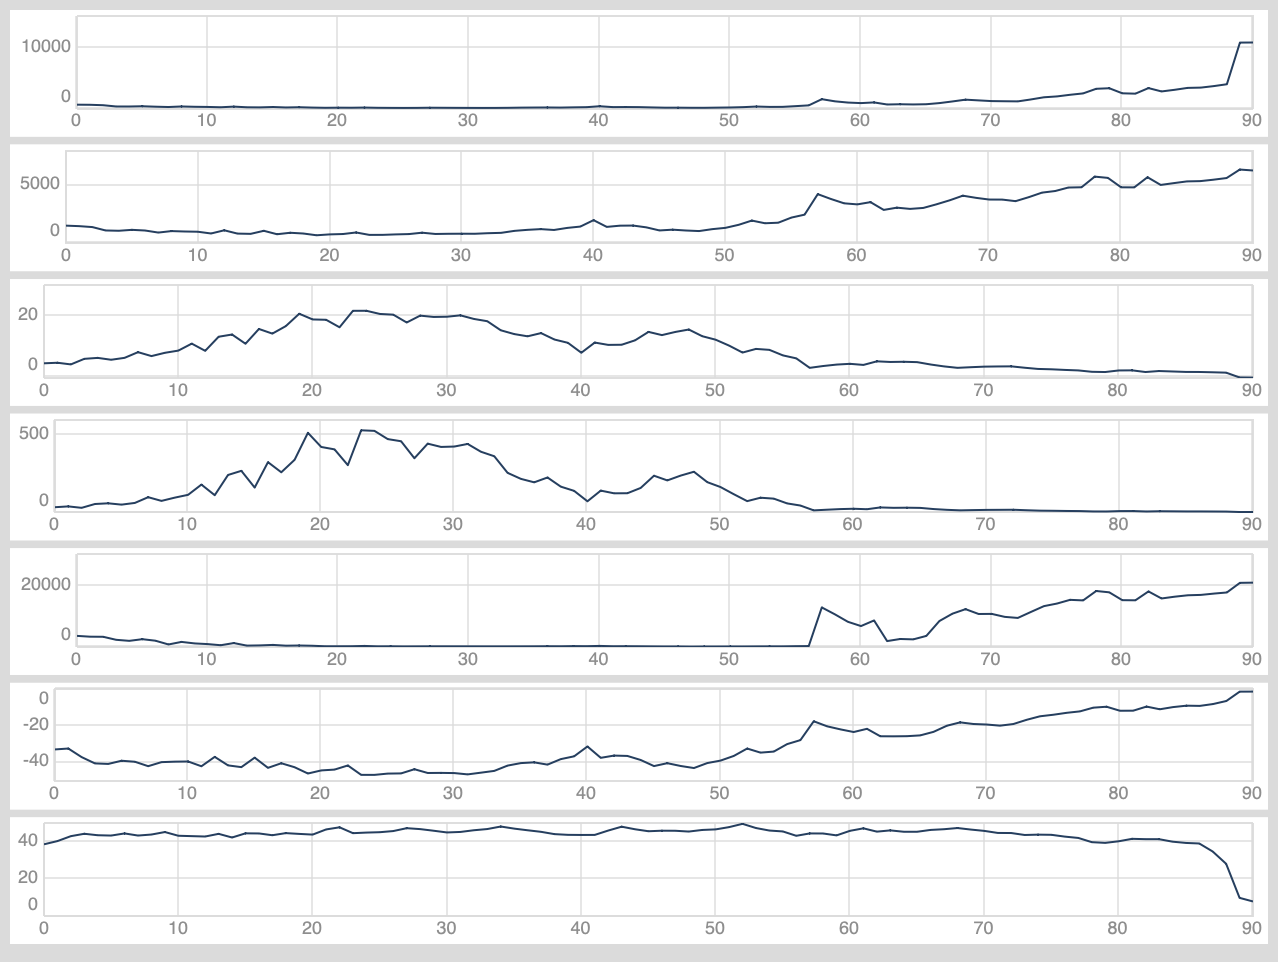


-> Buffer(490, 91, 7, 86.1328125, nil)

In [17]:
~spectralBuffer.loadToFloatArray(action: {|array|
    plot.(array.clump(7).flop.plot);
});

Comare this to the amplitude plot of the actual sample.
The moment the sample becomes silence the spectral analysis algorithm returns really different values than before: as we approach silence, it becomes more difficult for the algorithm to detect a spectral centroid.

If this wouldn't be an introduction to FluCoMa it would probably be a good idea to only run the spectral analysis where there is no silence.

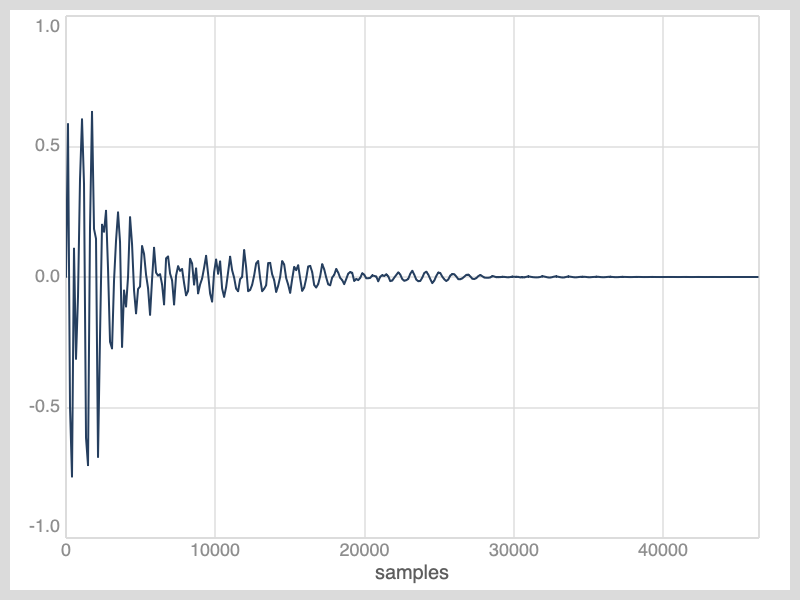


-> an Image

In [18]:
plot.(~sample.plot);

$B_\text{spctral}$ has the shape of $n \times m$, where $n$ is denpedent on time.
This is not ideal because we want to representation our sample through a fixed number of parameters for each sample - and therefore our number of parameters shouldn't be dependent of time.
We therefore need to aggregate the value along the time dimension so the number of values that represent the sample becomes independent of the length of the sample.
This can be done via `FluidBufStats` in FluCoMa.

This will aggregate each feature dimension by creating e.g. the

* mean
* standard deviation
* ...

along its time dimension for each of the previously calculated parameters.
Therefore the aggregated buffer will have the dimensionality of

$$
B_\text{stat}: \underbrace{k}_{\text{\# aggregations}} \times \underbrace{m}_{\text{\# analysis}}
$$

In [19]:
~statsBuffer = Buffer.alloc(server: s, numFrames: 1);

FluidBufStats.processBlocking(
    server: s,
    source: ~spectralBuffer,
    stats: ~statsBuffer
);

// acts as s.sync to wait for the server to catch up
~statsBuffer.loadToFloatArray;

~statsBuffer;

-> Buffer(491, 7, 7, 86.1328125, nil)

Since the stats buffer is a two dimensional matrix it is still necessary to flatten this to a single vector of length $l$, so

$$
B_\text{flat}: km = l
$$

In [24]:
~flatBuffer = Buffer.alloc(server: s, numFrames: 1);

FluidBufFlatten.processBlocking(
    server: s,
    source: ~statsBuffer,
    destination: ~flatBuffer,
);

// acts as s.sync to wait for the server to catch up
~flatBuffer.loadToFloatArray;

~flatBuffer;

-> Buffer(495, 49, 1, 86.1328125, nil)

### Prepare whole dataset

Since we finished all the necessary data processing for now, the next step is to perform this analysis for every sample.
In order to store our analysis results we will use a `FluidDataSet` which allows to store a vector under a given ID and therefore has the dimensionality of

$$
D_\text{dataset}: \underbrace{x}_{\text{\# samples}} \times \underbrace{l}_{\text{\# parameters}}
$$

Using the excel spreadsheet as an analogy: We will create a spreadsheet with $l$ columns (one for each parameter) and $x$ rows (one for each sample).

In [25]:
~dataset = FluidDataSet(server: s);

fork {
	// reuse buffers accross analysis
	var spectralBuf = Buffer.alloc(server: s, numFrames: 1);
	var statsBuf = Buffer.alloc(server: s, numFrames: 1);
	var flattenBuf = Buffer.alloc(server: s, numFrames: 1);
	~sampleBuffers.do({|sampleBuffer, i|

		FluidBufSpectralShape.process(
			server: s,
			source: sampleBuffer,
			features: spectralBuf,
			select: [\centroid, \spread],
		);
		s.sync;

		FluidBufStats.process(
			server: s,
			source: spectralBuf,
			stats: statsBuf,
			select: [\mean, \std],
		);
		s.sync;

		FluidBufFlatten.process(
			server: s,
			source: statsBuf,
			destination: flattenBuf,
		);
		s.sync;

		~dataset.addPoint(
			identifier: i,
			buffer: flattenBuf,
		);
	});

    // free analysis buffers
    [\spectralBuf, \statsBuf, \flattenBuf].do({|b| b.free;});
    
	"finished processsing".postln;
};

-> a Routine

One can use `~dataset.print` to inspect the values stored within a dataset.

## Training the PCA

PCA is a dimensionality reduction algorithm: the basic.
One fundamental idea here is that the algorithm solely tries to find structure within the data without telling the algorithm which kind or class of data it is currently looking at - solely the statistical properties of the seen data will be used to find a good mapping of the high-dimensional data in lower dimensions.
One can therefore think of PCA as a tool to find the best position for a flashbulb such that the shadow of our lightened hands represent the most information possible on the canvas, such that we hopefully can translate some structure of the 3 dimensional hands onto the 2 dimensional wall.

There is a fantastic video by the numberphile YouTube channel about PCA which is worth looking if you want to understand the principle behind PCA.

<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/TJdH6rPA-TI?si=pUhCIDFPaw16Z6s3" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

Since PCA requires a *standardized* dataset for each feature/dimension, we need to transform our given dataset in such a way.
*Standarized* hereby means that the mean of all datapoints within one dimension must have a mean of zero and a standard deviation of 1.
This is necessary such that our lightbulb doesn't have to cover values between $100$ and $10000$ and on another dimension between $0$ and $0.1$, which would make it a hard time to find a proper position to capture all nuances within the data.
Instead all values will be located around $0$.

```{admonition} Example
Given a dataset $D = \lbrace 20, 30, 70 \rbrace$.
In order to make its mean $0$ we need to shift the values of the dataset by its current mean $\mu$, so

$$
\mu = \frac{1}{N} \sum_{i=0}^{N} = \frac{1}{3} \left(20 + 30 + 70\right) = 40
$$

This is possible because we are not interested in the absolute values but instead in the relativity towards all other parameters.
We are also not interested in the absolute distance between each value within our parameter dimension, so we also have to scale/unify the spread of our dataset.
This is achived by transforming the dataset to having a standard deviation of $1$.

To calculate the current standard deviation $\sigma$ of our dataset we need to use

$$
\sigma = \sqrt{\frac{1}{N} \sum_{i=1}^{N} \left(x_i - \mu \right)^2} = \sqrt{\frac{(20-40)^2 + (30-40)^2 + (70-40)^2}{3}} = \sqrt{\frac{1400}{3}} \approx 21.6
$$

Given these two values, we now can transform our dataset via $z = \frac{x - \mu}{\sigma}$ for each $x \in D$, so the new dataset becomes $D_\text{standard} \approx \lbrace -0.93, -0.46, 1.39 \rbrace$.
```

FluCoMa thankfully provides us a convenient way to apply this transformation to our existing dataset.

In [26]:
~datasetStandardized = FluidDataSet(server: s);
FluidStandardize(server: s).fitTransform(sourceDataSet: ~dataset, destDataSet: ~datasetStandardized);

-> FluidStandardize(1478)

Since everything is now prepared, we can now train the PCA upon our data.
We do this by converting our existing standardized dataset of $49$ dimensions to a new dataset with $2$ dimensional vectors.

In [30]:
~datasetPca = FluidDataSet(server: s);

~pca = FluidPCA(server: s, numDimensions: 2).fitTransform(
	sourceDataSet: ~datasetStandardized,
	destDataSet: ~datasetPca,
);

-> FluidPCA(1482)

In [28]:
~datasetPca.print;

-> FluidDataSet(1479)

## Evaluate

Since we now converted the samples to a dataset through some analysis and converted this high dimensional space down again to two dimensions it is time to inspect the results.

We can make use of the `FluidPlotter` class which helps us to inspect a given dataset.

In [29]:
// this buffer stores the clicked value

var clicked = Buffer.alloc(server: s, numFrames: 2);
~datasetPca.dump({|dict|
	defer {
        // adjust xmin, xmax, ymin, ymax according to your pca dataset
		FluidPlotter(dict: dict, xmin: -10, xmax: 10, ymin: -10, ymax: 10, mouseMoveAction: {|view, xPos, yPos mod, button, count|
			fork {
                // set the clicked buffer to the value we received
				clicked.sendCollection(collection: [xPos, yPos]);
				s.sync;
                // get the nearest sample given the clicked position
				~datasetPca.kNearest(buffer: clicked, k: 1, action: {|i|
                    // select the clicked sample from our sample array and play it
					~samples.select({|buf| buf.bufnum == i.asInteger}).first.postln.play;
				});
			};
		});
	};
})

-> FluidDataSet(1479)

### Running on the server in realtime

Currently we operated solely within the language of SuperCollider, and although this is already very nice already, this is not something which wasn't possible prior by using Python.
FluCoMa really shines when it operates upon a stream of live data such as audio signals, so we also want to take a look how we can use the trained PCA model on the server.

Since looking up the k nearest neighbours for a given point within a dataset is a computational heavier task, we need to train a [k-d tree](https://en.wikipedia.org/wiki/K-d_tree) upon our dataset to provide us an approximate but fast guess upon the neighbors for a given point.


In [31]:
~tree = FluidKDTree(s, numNeighbours: 1);
~tree.fit(dataSet: ~datasetPca);

-> FluidKDTree(1483)

The k nearest neighbor implementation of FluCoMa will return the label of the given point within the language, but since this label can also be a string, the server will instead return the coordinates of the closest matched point within the dataset since the server can not handle strings but only floats.
In order to circumvent this restriction, it is possible to provide a `lookupDataset` to the k-d-tree on the server, which maps allows to return another float value for a matching index of both datasets.

Such a dataset can be created via

In [32]:
var lookupDict = Dictionary.newFrom(["cols", 1, "data", Dictionary.new]);

~datasetPca.dump({|d|
	d["data"].do({|k, v|
		lookupDict["data"][v.asString] = ~sampleBuffers[v].bufnum;
	});
	~lookupDataset = FluidDataSet(s).load(dict: lookupDict);
});

-> FluidDataSet(1481)

Since FluCoMa operate upon buffers, it is always necesary to convert our control values to Buffer via `FluidKrToBuf` (or vice versa via `FluidBufToKr`).

In [33]:
Ndef(\x, {
    // buffers to store our data passed to flucoma
	var coordinate = LocalBuf(numFrames: 2);
	var sample = LocalBuf(numFrames: 1);
    
	var numSample;
	var trigger = Impulse.kr(\speed.kr(2.0));
    
	FluidKrToBuf.kr(
		krStream: [\x.kr(0.0), \y.kr(0.0)],
		buffer: coordinate,
	);
	~tree.kr(
		trig: trigger,
		inputBuffer: coordinate,
		outputBuffer: sample,
		numNeighbours: 1,
		lookupDataSet: ~lookupDataset
	);
	numSample = FluidBufToKr.kr(
		buffer: sample
	).poll(trig: 4.0,label: \sample);
	PlayBuf.ar(
		numChannels: 1,
		bufnum: numSample,
		trigger: trigger,
	);
}).play.gui;

-> a NdefGui

## Further Tasks

Optional tasks which are left as exercise to the reader.

* [ ] Check how the spectral analysis performs when the sample becomes silent - is this problematic? Is it possible to neglect the silent parts of the sample?
* [ ] Add such metrics such as length and amplitude
* [ ] Is the mean an actual good value for a spectral centroid? Why not?
* [ ] How does the FFT parameters of the SpectralShape analysis affect the results?
* [ ] Use a dataset which consists of two different kind of sounds (e.g. snare and kick) - find good parameters of the pre-processing to separate those two classes. PCA will not be told what classes the sounds are from during training!
* [ ] Translating between higher and lower dimensions can be usefule to navigate through a set of presets: Create a list of presets for a given complex sound and navigate though them via PCA. What is the problem if the reduced dimension is $1$?
* [ ] You can also use the PCA to translate (live) signals to another representation - e.g. while `FluidBufSpectralShape` operates upon buffers, there is also `FluidSpectralShape` which operates upon signals. Train a PCA model on a variety of data and use it to control the parameters of a sound through a given input source.